# Métodos estocásticos

Se refiere a procesos cuya evolución en el tiempo es aleatoria, así que tendremos que hacer algo de incapié en la generación de números aleatorios.

In [2]:
import random

No te limites a los cuatro ejemplos.  Mira la ayuda del módulo ejecutando `help(random)`.  Vamos a repasar algunas de las construcciones más frecuentes.

In [3]:
random.randrange(0, 100)

46

In [4]:
random.choice('aeiou')

'i'

In [5]:
random.choices('aeiou',[12.53, 13.68, 6.25, 8.68, 3.93]) # https://es.wikipedia.org/wiki/Frecuencia_de_aparici%C3%B3n_de_letras

['a']

In [6]:
random.uniform(1,100)

63.370388936730166

Todo se basa en generadores pseudoaleatorios con un periodo muy muy grande, pero para empezar se elige uno de forma completamente aleatoria.  Esa primera elección (semilla) viene del sistema operativo.  Pero podemos cambiarla a mano.

In [ ]:
random.seed(0)

Entonces la secuencia es repetible, y eso facilita la depuración de errores.

In [7]:
random.seed(0)
print([random.randrange(0,10) for i in range(10)])
random.seed(0)
print([random.randrange(0,10) for i in range(10)])

[6, 6, 0, 4, 8, 7, 6, 4, 7, 5]
[6, 6, 0, 4, 8, 7, 6, 4, 7, 5]


## 1. Paseo aleatorio (random walk)

Modelado de borracho en cuadrícula. Siguiente paso aleatorio en cualquier dirección. ¿Tiende a separarse del origen?

Conectado con multitud de procesos físicos (e.g. difusión) y de otro tipo (e.g. precio de acciones).

Empezamos modelando la posición.

In [14]:
class Location(object):
  def __init__(self, x, y):
    self.x, self.y = x, y
  
  def getX(self): return self.x
  def getY(self): return self.y

  def distanceFrom(self, otra):
    return ((self.x - otra.getX())**2 + (self.y-otra.getY())**2)**0.5

  def move(self, dx, dy):
    return Location(self.x + dx, self.y + dy)

El borracho puede tener diversos comportamientos.  Lo modelamos como una jerarquía de clases.  La parte común (posición y acceso a la posición) se queda en la clase base `Drunk`, la parte específica (movimiento) queda en la especialización correspondiente de `Drunk`.

In [15]:
class Drunk(object):
  def __init__(self):
    self.loc = Location(0,0)

  def getLocation(self):
    return self.loc

class UniformDrunk(Drunk):
  def move(self):
    dx, dy = random.choice([(-1,0),(1,0),(0,-1),(0,1)])
    self.loc = self.loc.move(dx,dy)

class NorthDrunk(Drunk):
  def move(self):
    dx, dy = random.choices([(-1,0),(1,0),(0,-1),(0,1)], [0.2,0.2,0.2,0.4])
    self.loc = self.loc.move(dx,dy)

Por último podemos modelar la cuadrícula en la que se mueve. Casi todo se delega en la clase que sabe.

In [16]:
class Field(object):
  def __init__(self):
    self.drunk = None

  def addDrunk(self, drunk):
    if self.drunk:
      raise ValueError('Ya hay borracho')
    self.drunk = drunk

  def move(self): 
    self.drunk.move()
    return self.distance()

  def distance(self):
    return self.drunk.getLocation().distanceFrom(Location(0,0))


Para usarlo simplemente creamos un tablero y añadimos un borracho.

In [17]:
field = Field()
field.addDrunk(UniformDrunk())


Simular la evolución de la distancia al origen es trivial.

In [24]:
d = [field.move() for _ in range(100)]

In [19]:
import matplotlib.pyplot as plt

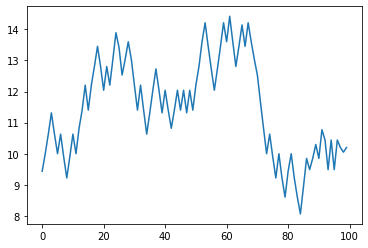

In [25]:
plt.plot(d)

## 2. Simulación de Montecarlo

El método usado para calcular el grosor de hormigón necesario para protegerse de una explosión atómica.

### Problema de Pascal (s. XVII)

¿Compensa apostar a que sacaremos doble 6 en 24 jugadas?

En la época era un problema difícil, ahora es trivial pero vamos a resolverlo por simulación.

In [27]:
def dado():
  return random.choice(range(1,7))

def apuesta_pascal():
  for i in range(24):
    if (dado(),dado()) == (6,6):
      return True
  return False

def comprueba_pascal(intentos):
  return sum(apuesta_pascal() for i in range(intentos))/intentos

In [36]:
comprueba_pascal(100000)

0.49098

La teoría dice que es:

$$ P = 1 - \left(\frac{35}{36}\right)^{24} $$

In [35]:
1 - (35/36)**24

0.4914038761309034

### Juego de Craps

Es un [juego de dados](https://casinoalto.com/reglas/craps/) típico en casinos.

El lanzador tiene que apostar a **línea de pase** o a **barra de no pase**.  Usaremos la simplificación del libro de texto, en la que las dos posibles apuestas funcionan así:

*   Si apuesta a **línea de pase** en la primera tirada gana si sale 7 u 11 y pierde con 2,3 o 12.  El resto de números obliga a seguir tirando. El resultado obtenido se convierte en el `punto` y debe volver a obtenerlo antes de sacar un 7 para ganar.

*   Si a puesta a **barra de no pase** en la primera tirada gana con un 2 o un 3, empata con un 12, y pierde con 7 u 11.  El resto de los números obliga a seguir tirando.  El resultado obtenido se convierte en el `punto` y debe obtener un 7 antes de volver a obtener el `punto` para ganar.



In [46]:
reglas_craps = {
    'línea de pase' : {
        'primera': {
            'win':  lambda x,_: x in (7,11) ,
            'loss': lambda x,_: x in (2,3,12) ,
        },
        'resto': {
            'win':  lambda x, punto: x == punto ,
            'loss': lambda x, punto: x == 7
        }
    },
    'barra de no pase': {
        'primera': {
            'win':  lambda x,_: x in (2,3) ,
            'loss': lambda x,_: x in (7,11) ,
            'push': lambda x,_: x == 12
        },
        'resto': {
            'win':  lambda x, punto: x == 7 ,
            'loss': lambda x, punto: x == punto,
        }        
    }
}

class CrapsGame(object):
  def __init__(self):
    self.results = { apuesta: { k:0 for k in reglas_craps[apuesta]['primera'] } for apuesta in reglas_craps }

  def play(self):
    punto = dado() + dado()
    done = [ self.tirada(apuesta, punto) for apuesta in self.results ]
    while True:
      if all(done): return
      x = dado() + dado()
      done = [ self.tirada(apuesta, x, punto) if not ok else ok for apuesta,ok in zip(self.results.keys(), done) ]

  def tirada(self, apuesta, x, punto = 0):
      r = self.results[apuesta]
      f = reglas_craps[apuesta]['resto' if punto else 'primera']
      for key in f:
        if f[key](x, punto):
          r[key] += 1
          return True
      return False
  
  def runs(self, n):
    for i in range(n):
      self.play()


In [47]:
g = CrapsGame()
g.runs(100000)
g.results

{'barra de no pase': {'loss': 49259, 'push': 2837, 'win': 47904},
 'línea de pase': {'loss': 50741, 'win': 49259}}